### Scalling up:from start small to All in 
迁移学习中的 "scaling up" 指的是通过增加模型的规模（如深度、宽度等）或使用更大的数据集来提高模型的性能。这种方法旨在使迁移学习更为有效，以便在新任务上更好地利用从源任务中学到的知识。

具体而言，"scaling up" 可以包含以下几个方面：

1. **增加模型深度：** 将模型的层数增加，使其更深。更深的模型可能能够学到更复杂、更抽象的特征表示，从而在目标任务上获得更好的性能。

2. **增加模型宽度：** 将模型中每一层的节点数目增加，使其更宽。更宽的模型有更多的参数，能够更灵活地适应不同任务的特征。

3. **使用更大的数据集：** 在目标任务上使用更大规模的数据集进行训练。更大的数据集通常能够提供更多的样本和更丰富的信息，有助于提高模型的泛化性能。

4. **Fine-tuning 更多层次：** 在迁移学习中，除了微调顶层，还可以考虑逐渐解冻更多的层次，并进行更深入的微调。这样可以更充分地利用在源任务上学到的特征。

5. **使用更复杂的模型结构：** 采用更为复杂的模型结构，如最新的架构或者经过验证在大规模数据集上表现良好的模型。

总体来说，"scaling up" 是通过增加模型的规模以及使用更大的数据集来增强模型的表示能力和泛化性能，以在新任务上获得更好的性能。然而，需要注意的是，在使用更大的模型和数据集时，也可能需要更多的计算资源。

**现在为止做的是10类foods数据的分类，这次要做101种数据分类**

1. 载入百分之十的foods101数据
2. 特征抽取
   1. modelcheckpoint
   2. data augmentation
   3. base model with efficientnetb0 from keras.applications
   4. output layer with 101 hidden neurons
   5. compile
   6. fit by training data and validation data with 15% of test data to save time
3. 模型微调
4. 保存和载入模型
5. 评价和分析错误预测数据
6. 用真实数据进行预测

In [1]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [7]:
# Download data from Google Storage (already preformatted)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 
# unzip_data("101_food_classes_10_percent.zip")
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

In [3]:
# check data
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and0 images in '101_food_classes_10_percent'.
There are 101 directories and0 images in '101_food_classes_10_percent/test'.
There are 0 directories and250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and250 images in '101_food_classes_10_percent/test/club_sandwich'.
There are 0 directories and250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and250 images in '101_food_classes_10_percent/test/cup_cakes'.
There are 0 directories and250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and250 images in '101_food_classes_10_percent/test/gnocchi'.
There are 0 directories and250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and250 images in '101_food_classes_10_percent/test/samosa'.
There are 0 directories and250 images in '101_food_classes_10_percent/test/donuts'.
There are 0 directories and250 images in '101_food_classes_10_percen

In [8]:
# setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [9]:
# checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [10]:
# create data augmentation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
], name="data_augmentation")

In [16]:
# setup base model and freeze its layers to extract features
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avarage_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  multiple                  0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_avarage_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [17]:
# compile 
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.legacy.Adam(),
              metrics=["accuracy"])
# fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 254s 1s/step - loss: 3.5263 - accuracy: 0.2400 - val_loss: 2.7773 - val_accuracy: 0.3980
Epoch 2/5
237/237 [==============================] - 259s 1s/step - loss: 2.4178 - accuracy: 0.4510 - val_loss: 2.2843 - val_accuracy: 0.4690
Epoch 3/5
237/237 [==============================] - 253s 1s/step - loss: 2.0501 - accuracy: 0.5143 - val_loss: 2.0631 - val_accuracy: 0.4958
Epoch 4/5
237/237 [==============================] - 252s 1s/step - loss: 1.8377 - accuracy: 0.5529 - val_loss: 1.9325 - val_accuracy: 0.5138
Epoch 5/5
237/237 [==============================] - 253s 1s/step - loss: 1.6992 - accuracy: 0.5859 - val_loss: 1.8862 - val_accuracy: 0.5201


In [11]:
# evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 494s 625ms/step - loss: 1.6183 - accuracy: 0.5770


[1.6182515621185303, 0.5769504904747009]

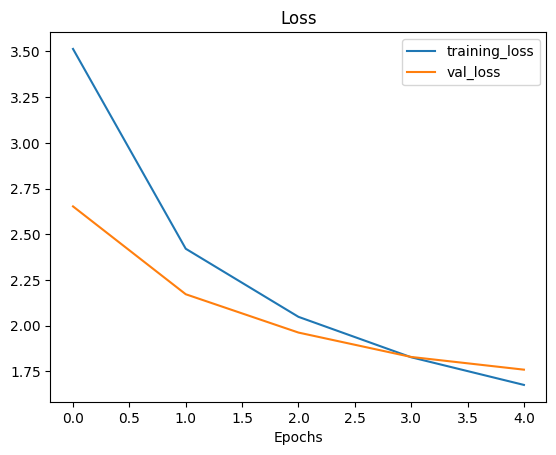

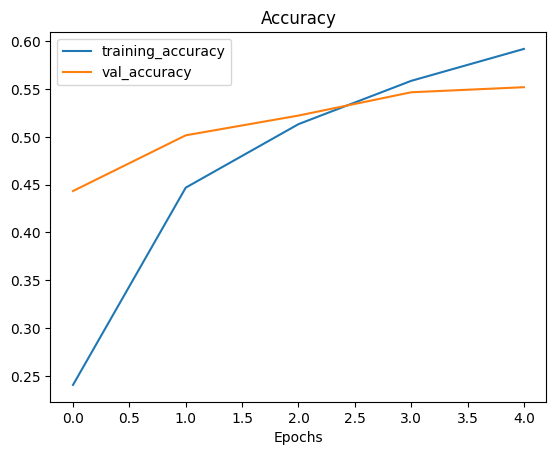

In [12]:
plot_loss_curves(history_all_classes_10_percent)

In [18]:
# fine-tuning
# unfreeze all the base model
base_model.trainable = True

# refreeze except last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [19]:
# recompile 
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.legacy.Adam(1e-4),
              metrics=["accuracy"])

In [20]:
# check layers
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 True
global_avarage_pooling True
output_layer True


In [21]:
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [22]:
# fine tune for 5 more epochs
fine_tune_epochs = 10
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 251s 1s/step - loss: 1.4868 - accuracy: 0.6271 - val_loss: 1.8397 - val_accuracy: 0.5222
Epoch 6/10
237/237 [==============================] - 247s 1s/step - loss: 1.3846 - accuracy: 0.6415 - val_loss: 1.8430 - val_accuracy: 0.5209
Epoch 7/10
237/237 [==============================] - 247s 1s/step - loss: 1.3255 - accuracy: 0.6492 - val_loss: 1.7987 - val_accuracy: 0.5307
Epoch 8/10
237/237 [==============================] - 251s 1s/step - loss: 1.2835 - accuracy: 0.6642 - val_loss: 1.7957 - val_accuracy: 0.5312
Epoch 9/10
237/237 [==============================] - 260s 1s/step - loss: 1.2349 - accuracy: 0.6698 - val_loss: 1.7780 - val_accuracy: 0.5365
Epoch 10/10
237/237 [==============================] - 265s 1s/step - loss: 1.1956 - accuracy: 0.6846 - val_loss: 1.8186 - val_accuracy: 0.5278


In [19]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 507s 642ms/step - loss: 1.4808 - accuracy: 0.6019


[1.4807603359222412, 0.6019009947776794]

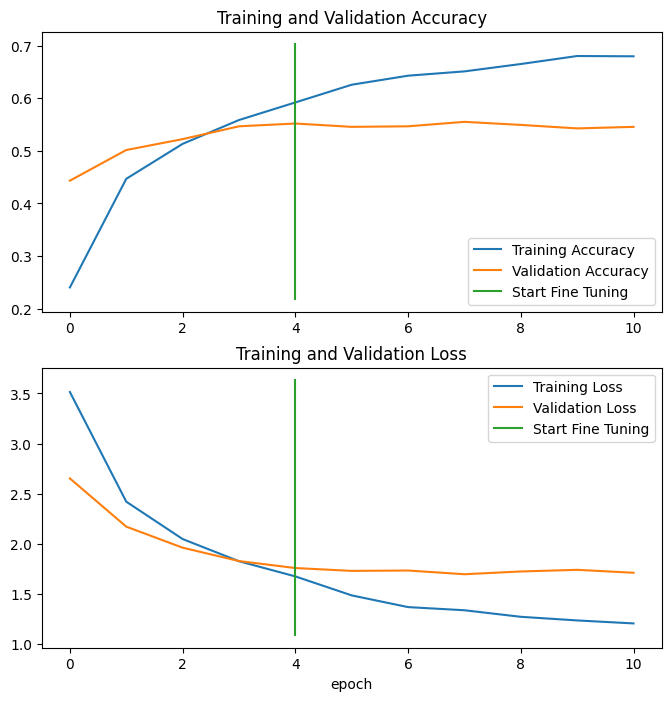

In [21]:
compare_historys(original_history=history_all_classes_10_percent,
                new_history=history_all_classes_10_percent_fine_tune,
                initial_epochs=5)

In [23]:
# # Save model to drive so it can be used later 
model.save("101_food_class_10_percent_saved_big_dog_model")

INFO:tensorflow:Assets written to: 101_food_class_10_percent_saved_big_dog_model/assets


INFO:tensorflow:Assets written to: 101_food_class_10_percent_saved_big_dog_model/assets


In [23]:
# import tensorflow as tf

# Download pre-trained model from Google Storage (like a cooking show, I trained this model earlier, so the results may be different than above)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
# saved_model_path = "06_101_food_class_10_percent_saved_big_dog_model.zip"
# unzip_data(saved_model_path)

# Note: loading a model will output a lot of 'WARNINGS', these can be ignored: https://www.tensorflow.org/tutorials/keras/save_and_load#save_checkpoints_during_training
# There's also a thread on GitHub trying to fix these warnings: https://github.com/tensorflow/tensorflow/issues/40166
# model = tf.keras.models.load_model("drive/My Drive/tensorflow_course/101_food_class_10_percent_saved_big_dog_model/") # path to drive model
# model = tf.keras.models.load_model(saved_model_path.split(".")[0]) # don't include ".zip" in loaded model path

In [24]:
# # Check to see if loaded model is a trained model
# loaded_loss, loaded_accuracy = model.evaluate(test_data)
# loaded_loss, loaded_accuracy

In [25]:
# make prediction with model
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 487s 615ms/step


In [26]:
pred_probs.shape

(25250, 101)

In [27]:
pred_classes = pred_probs.argmax(axis=1)

In [29]:
pred_classes, len(pred_classes)

(array([ 85,   0,   0, ...,  56, 100, 100]), 25250)

In [32]:
# unbatch test_data set to get y_labals
y_labels = []
for images, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())

In [33]:
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [34]:
# evaluate 
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6019009900990099

In [46]:
import numpy as np
np.isclose(results_all_classes_10_percent_fine_tune[1], sklearn_accuracy)

True

In [24]:
class_names = test_data.class_names

In [40]:
from helper_functions import make_confusion_matrix
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [42]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=classes,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.40      0.12      0.18       250
           1       0.69      0.62      0.65       250
           2       0.65      0.48      0.55       250
           3       0.67      0.62      0.64       250
           4       0.58      0.39      0.47       250
           5       0.64      0.31      0.42       250
           6       0.75      0.80      0.78       250
           7       0.83      0.70      0.76       250
           8       0.25      0.59      0.35       250
           9       0.32      0.74      0.45       250
          10       0.49      0.50      0.49       250
          11       0.67      0.51      0.58       250
          12       0.74      0.58      0.65       250
          13       0.51      0.61      0.56       250
          14       0.43      0.65      0.52       250
          15       0.30      0.40      0.35       250
          16       0.64      0.56      0.60       250
          17       0.43    

In [48]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.4,
  'recall': 0.12,
  'f1-score': 0.18461538461538463,
  'support': 250.0},
 '1': {'precision': 0.6888888888888889,
  'recall': 0.62,
  'f1-score': 0.6526315789473685,
  'support': 250.0},
 '2': {'precision': 0.6502732240437158,
  'recall': 0.476,
  'f1-score': 0.5496535796766743,
  'support': 250.0},
 '3': {'precision': 0.6666666666666666,
  'recall': 0.616,
  'f1-score': 0.6403326403326403,
  'support': 250.0},
 '4': {'precision': 0.5833333333333334,
  'recall': 0.392,
  'f1-score': 0.4688995215311005,
  'support': 250.0},
 '5': {'precision': 0.6446280991735537,
  'recall': 0.312,
  'f1-score': 0.42048517520215634,
  'support': 250.0},
 '6': {'precision': 0.7547169811320755,
  'recall': 0.8,
  'f1-score': 0.7766990291262137,
  'support': 250.0},
 '7': {'precision': 0.8285714285714286,
  'recall': 0.696,
  'f1-score': 0.7565217391304347,
  'support': 250.0},
 '8': {'precision': 0.2517123287671233,
  'recall': 0.588,
  'f1-score': 0.35251798561151076,
  'support'

In [50]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[classes[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.18461538461538463,
 'baby_back_ribs': 0.6526315789473685,
 'baklava': 0.5496535796766743,
 'beef_carpaccio': 0.6403326403326403,
 'beef_tartare': 0.4688995215311005,
 'beet_salad': 0.42048517520215634,
 'beignets': 0.7766990291262137,
 'bibimbap': 0.7565217391304347,
 'bread_pudding': 0.35251798561151076,
 'breakfast_burrito': 0.4487804878048781,
 'bruschetta': 0.49309664694280075,
 'caesar_salad': 0.5818181818181819,
 'cannoli': 0.6516853932584269,
 'caprese_salad': 0.5573770491803279,
 'carrot_cake': 0.5175718849840255,
 'ceviche': 0.3458904109589041,
 'cheese_plate': 0.5957446808510639,
 'cheesecake': 0.4461538461538462,
 'chicken_curry': 0.5124716553287982,
 'chicken_quesadilla': 0.5673076923076923,
 'chicken_wings': 0.6935483870967742,
 'chocolate_cake': 0.5849802371541502,
 'chocolate_mousse': 0.4146341463414634,
 'churros': 0.7334851936218679,
 'clam_chowder': 0.7560975609756098,
 'club_sandwich': 0.6487603305785123,
 'crab_cakes': 0.4274061990212072,
 'creme_bru

In [51]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
33        edamame  0.964844
63       macarons  0.879121
75            pho  0.858871
69        oysters  0.840816
45  frozen_yogurt  0.838710

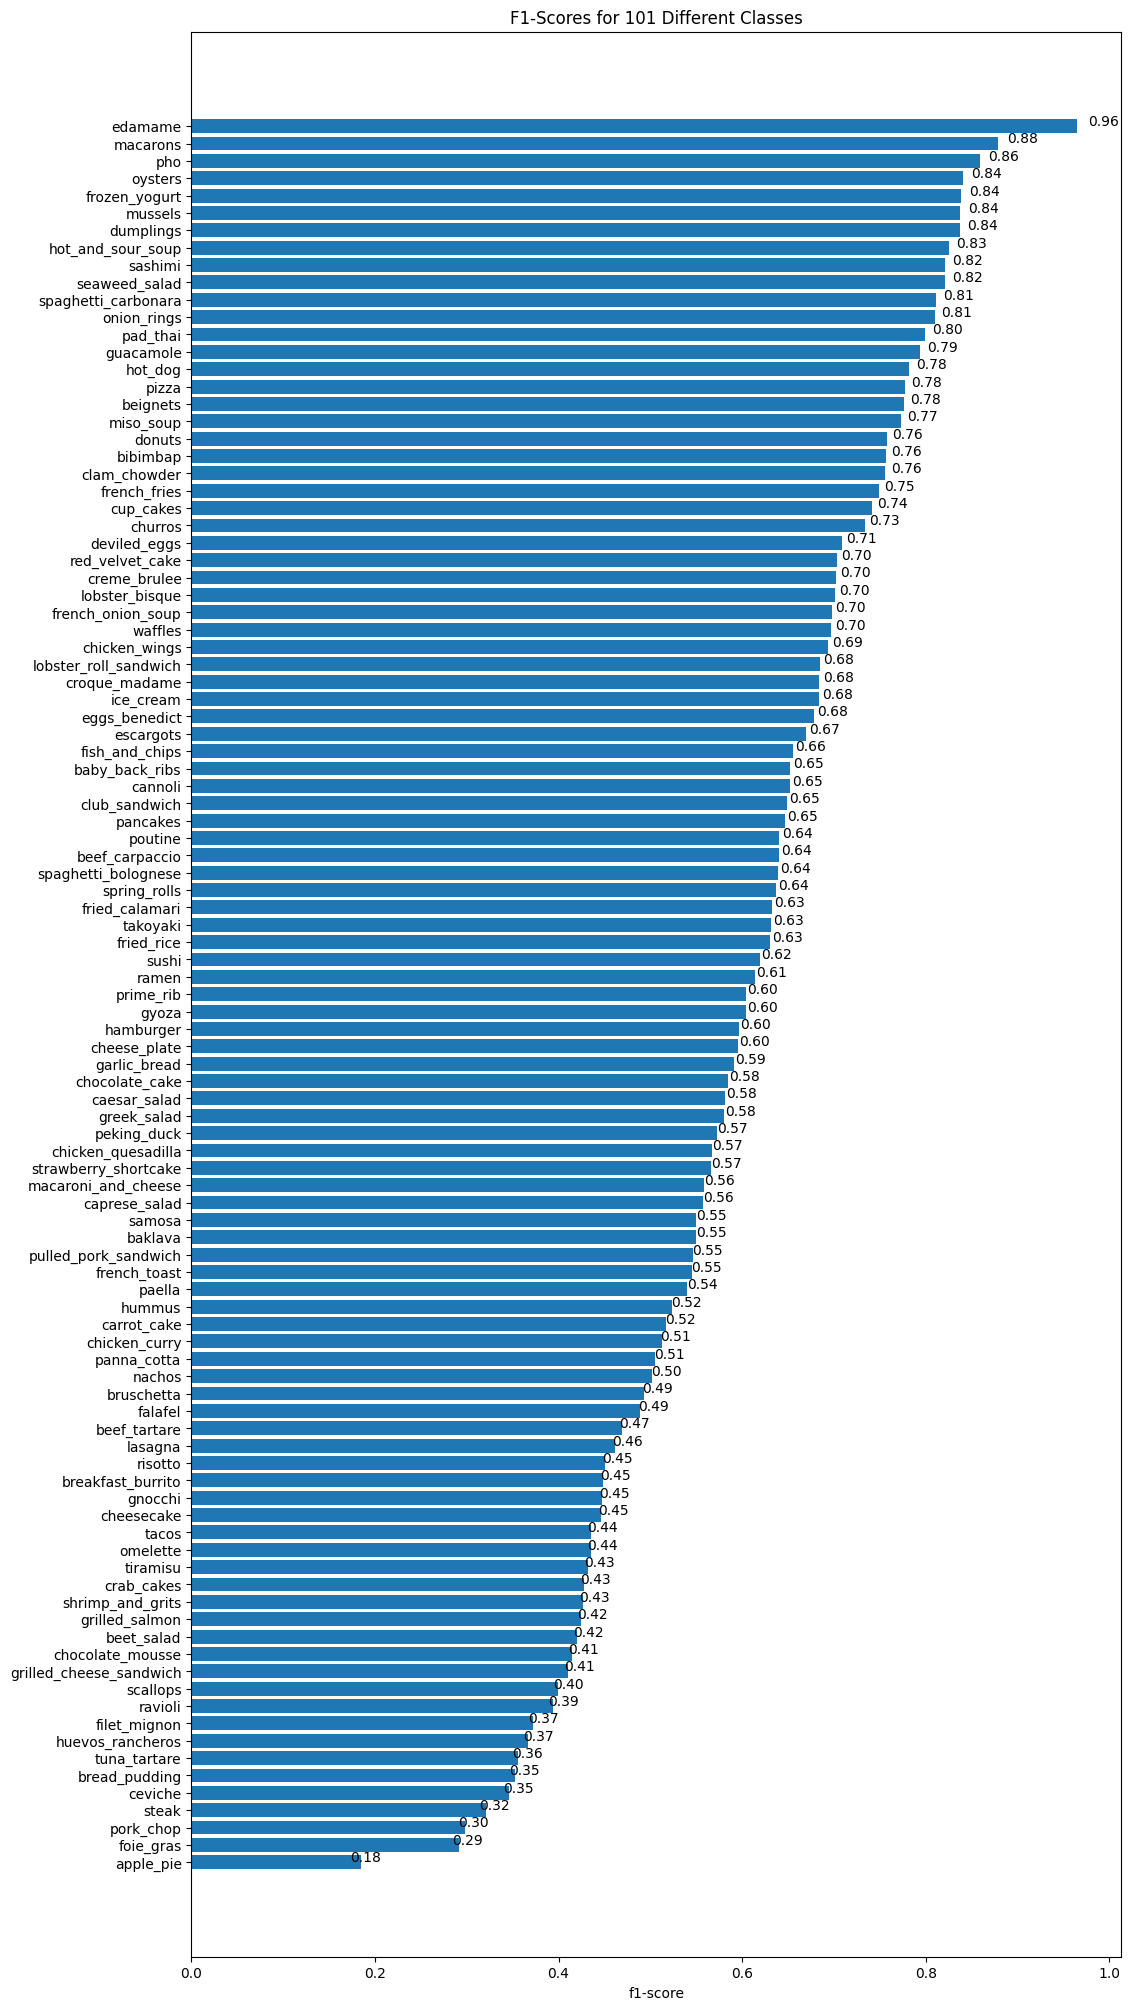

In [57]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 101 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [25]:
# load and prep image for predictions
# to-do:tf.io.read_file(),decode_image(),tf.image.resize(),scale image
def load_and_prep_image(filename, image_shape=224, scale=True):
    """
    Read in an image, turn it into an tensor, and resize it into (224, 224, 3).
    Parameters:
    -----------
    filename(str):string filename or target image
    image_shape(int):size to resize target to, default 224
    scale(bool):whether to scale pixel to (0, 1), default True
    """
    import tensorflow as tf
    # read in the image
    img = tf.io.read_file(filename)
    # decode it into a tensor
    img = tf.io.decode_image(img)
    # resize the image
    img = tf.image.resize(img, [image_shape, image_shape])
    # scale
    if scale:
        return img/255
    else:
        return img

1/1 [==============================] - 0s 41ms/step


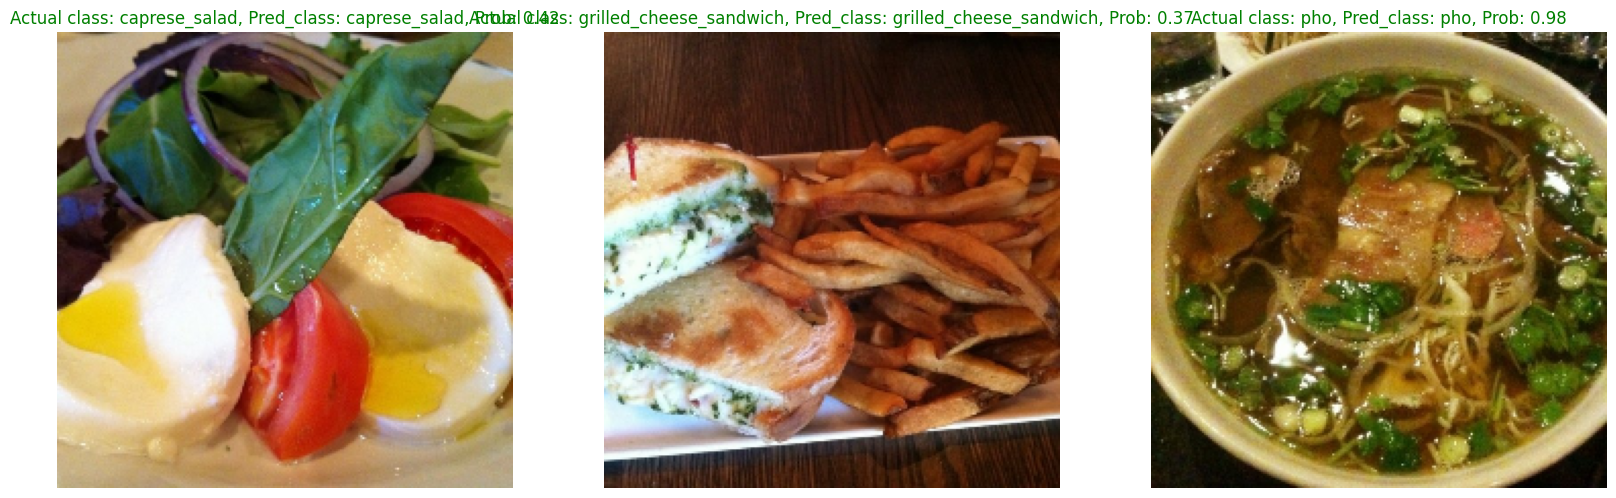

In [73]:
# make some predictions
# load some random image, make predictions, plot the original and prediction images
import os
import random

plt.figure(figsize=(20, 10))
for i in range(3):
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + class_name))
    filepath = test_dir + class_name + "/" + filename
    
    # load image and prep
    img = load_and_prep_image(filename=filepath, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]

    # plot the image
    plt.subplot(1, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class:
        title_color = "g"
    else:
        tilte_color = "r"
    plt.title(f"Actual class: {class_name}, Pred_class: {pred_class}, Prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);

In [74]:
# uncover the most wrong predictions
# 1. Get all of the image file paths in the test dataset using the list_files() method.
# 2. Create a pandas DataFrame of the image filepaths, ground truth labels, prediction classes, max prediction probabilities, ground truth class names and predicted class names.
# Note: We don't necessarily have to create a DataFrame like this but it'll help us visualize things as we go.
# 1. Use our DataFrame to find all the wrong predictions (where the ground truth doesn't match the prediction).
# 2. Sort the DataFrame based on wrong predictions and highest max prediction probabilities.
# 3. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [75]:
# get all file paths
filepaths = []
for filepath in test_data.list_files("101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
    filepaths.append(filepath.numpy())
filepaths[:10]

[b'101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [81]:
# create a dataframe
import pandas as pd
pred_df = pd.DataFrame({
    "img_path": filepaths,
    "y_true": y_labels,
    "y_pred": pred_classes,
    "pred_conf": pred_probs.max(axis=1),
    "y_true_classname": [class_names[i] for i in y_labels],
    "y_pred_classname": [class_names[i] for i in pred_classes]
})
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      85   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  
0   0.499795        apple_pie           samosa  
1   0.606732        apple_pie        apple_pie  
2   0.331060        apple_pie        apple_pie  
3   0.280754        apple_pie    bread_pudding  
4   0.762244        apple_pie    bread_pudding

In [82]:
# add the correct column
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'101_food_classes_10_percent/test/apple_pie/1...       0      85   
1  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
2  b'101_food_classes_10_percent/test/apple_pie/1...       0       0   
3  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   
4  b'101_food_classes_10_percent/test/apple_pie/1...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.499795        apple_pie           samosa         False  
1   0.606732        apple_pie        apple_pie          True  
2   0.331060        apple_pie        apple_pie          True  
3   0.280754        apple_pie    bread_pudding         False  
4   0.762244        apple_pie    bread_pudding         False

In [83]:
# get the top 100 wrong
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong

img_path  y_true  y_pred  \
14482  b'101_food_classes_10_percent/test/hummus/8476...      57      51   
23797  b'101_food_classes_10_percent/test/sushi/16593...      95      86   
4836   b'101_food_classes_10_percent/test/chicken_que...      19       9   
9402   b'101_food_classes_10_percent/test/filet_migno...      37      79   
21400  b'101_food_classes_10_percent/test/samosa/3140...      85      92   
...                                                  ...     ...     ...   
15115  b'101_food_classes_10_percent/test/lobster_bis...      60      24   
6757   b'101_food_classes_10_percent/test/creme_brule...      27      45   
2030   b'101_food_classes_10_percent/test/bread_puddi...       8      41   
15511  b'101_food_classes_10_percent/test/macaroni_an...      62      32   
15142  b'101_food_classes_10_percent/test/lobster_bis...      60      64   

       pred_conf     y_true_classname   y_pred_classname  pred_correct  
14482   0.997607               hummus          guacamole         False  
23797   0.997278                sushi            sashimi         False  
4836    0.996418   chicken_quesadilla  breakfast_burrito         False  
9402    0.995711         filet_mignon          prime_rib         False  
21400   0.995410               samosa       spring_rolls         False  
...          ...                  ...                ...           ...  
15115   0.945115       lobster_bisque       clam_chowder         False  
6757    0.944603         creme_brulee      frozen_yogurt         False  
2030    0.943821        bread_pudding  french_onion_soup         False  
15511   0.943727  macaroni_and_cheese          dumplings         False  
15142   0.943173       lobster_bisque          miso_soup         False  

[100 rows x 7 columns]

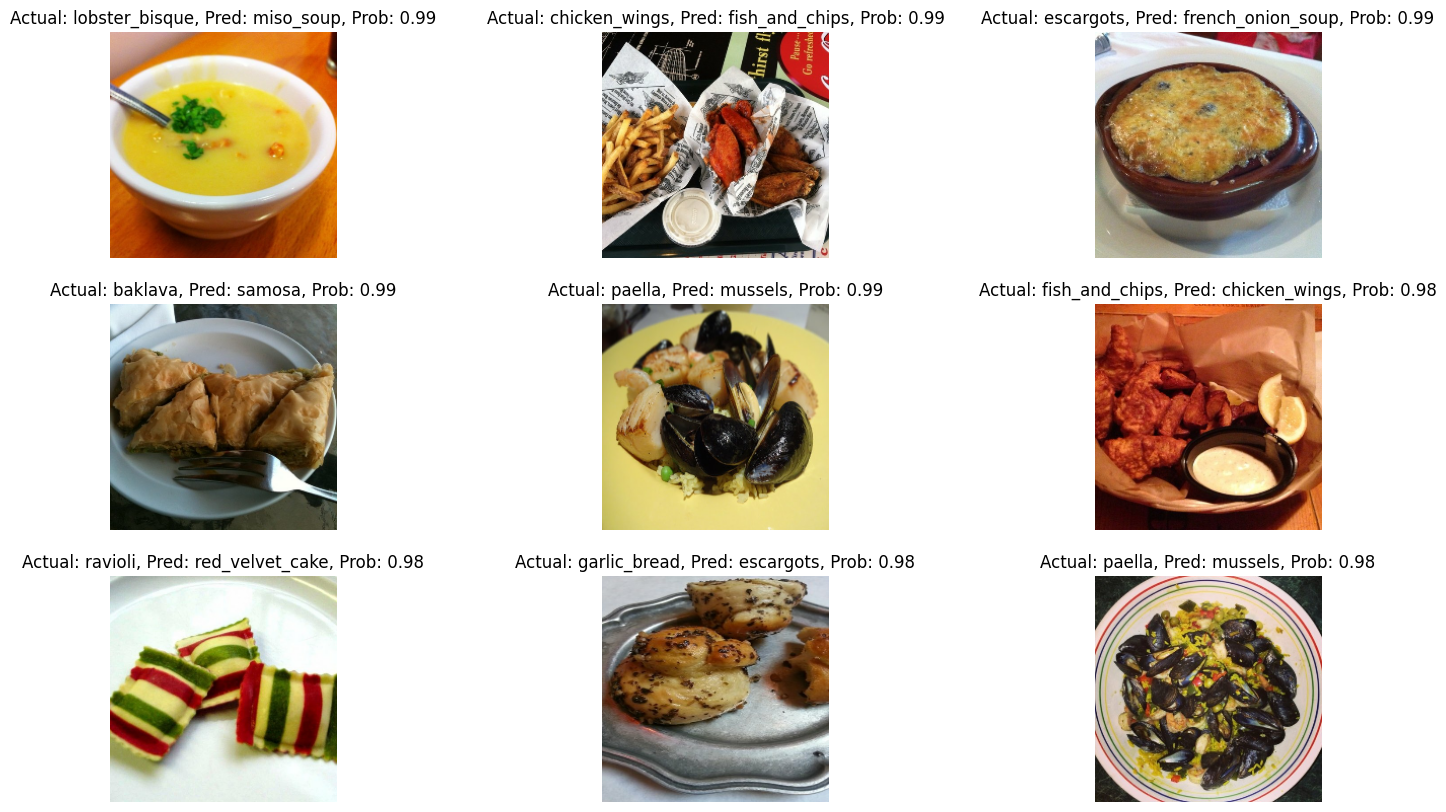

In [88]:
# visualize some of the wrong predictions
# The itertuples() method generates an iterator object of the DataFrame, returning each row as a Pyton Tuple object.
images_to_view = 9
start_index = 10
plt.figure(figsize=(18, 10))
for i, row in enumerate(top_100_wrong[start_index: start_index + images_to_view].itertuples()):
    # print(i, row)
    plt.subplot(3, 3, i+1)
    img = load_and_prep_image(row[1], scale=True)
    _, _, _, _, pred_conf, y_true_classname, y_pred_classname, _ = row
    plt.imshow(img)
    plt.title(f"Actual: {y_true_classname}, Pred: {y_pred_classname}, Prob: {pred_conf:.2f}")
    plt.axis(False)

**学习错误样本的意义是什么？**

数据改进，模型提升，特征分析，领域知识融入。

**主动学习**

主动学习（Active Learning）是一种机器学习的方法，其中模型能够根据当前的知识状态主动选择并询问有关标签的信息。与传统的监督学习方法不同，主动学习试图最大程度地减少需要标注的样本数量，从而降低了标注成本，提高了学习效率。

在传统的监督学习中，模型在训练过程中通过使用已标注的数据进行学习。然而，标注数据通常是昂贵和耗时的，特别是在大规模数据集上。主动学习的目标是在每次训练迭代中选择最具信息量的样本进行标注，以便模型在每一步都能更好地泛化到未标注数据上。

主动学习通常包括以下步骤：

1. **初始模型训练：** 使用初始的标注数据集训练一个基本模型。

2. **不确定性度量：** 使用该模型对未标注数据进行预测，并通过某种不确定性度量（例如，预测概率的不确定性或模型的置信度）来确定哪些样本可能是最具信息量的。

3. **样本选择：** 选择具有高不确定性的样本，即模型对其预测的不确定性较高的样本。

4. **标注：** 由领域专家或其他方式对选定的样本进行标注。

5. **模型更新：** 使用新标注的数据更新模型，重复上述步骤。

主动学习可以在不同领域中有很好的应用，尤其是在数据标注成本高、数据集规模庞大的情况下。它有助于提高模型的性能，同时最小化标注数据的使用，从而在资源有限的情况下实现更好的泛化性能。

In [2]:
# predict on Daniel's images
# Download some custom images from Google Storage
# Note: you can upload your own custom images to Google Colab using the "upload" button in the Files tab
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

In [4]:
from helper_functions import unzip_data
unzip_data("custom_food_images.zip") 

In [29]:
# get custom image path
import os
custom_food_images = ["custom_food_images/" + image_path for image_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/hamburger.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/pizza-dad.jpeg']

custom_food_images/hamburger.jpeg
1/1 [==============================] - 0s 43ms/step
custom_food_images/steak.jpeg
1/1 [==============================] - 0s 38ms/step
custom_food_images/sushi.jpeg
1/1 [==============================] - 0s 38ms/step
custom_food_images/chicken_wings.jpeg
1/1 [==============================] - 0s 41ms/step
custom_food_images/ramen.jpeg
1/1 [==============================] - 0s 39ms/step
custom_food_images/pizza-dad.jpeg
1/1 [==============================] - 0s 38ms/step


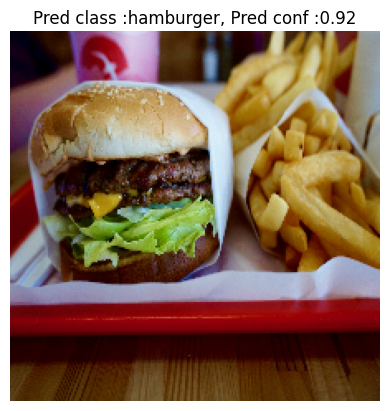

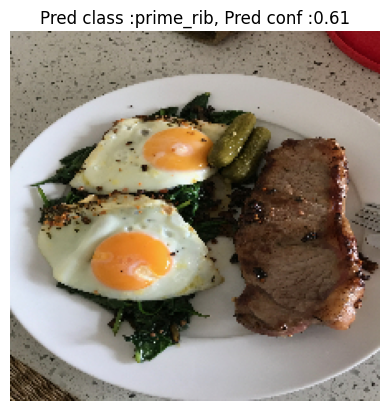

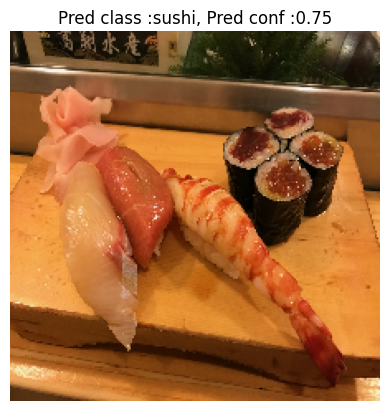

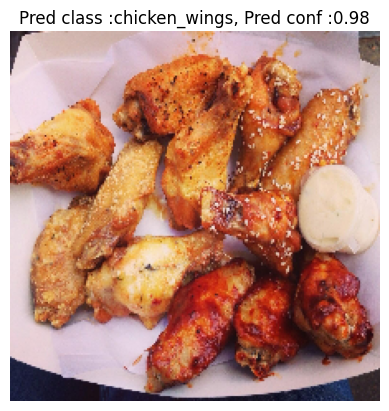

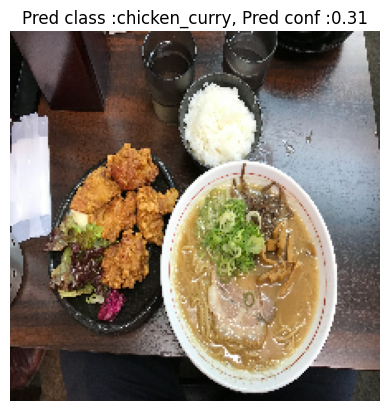

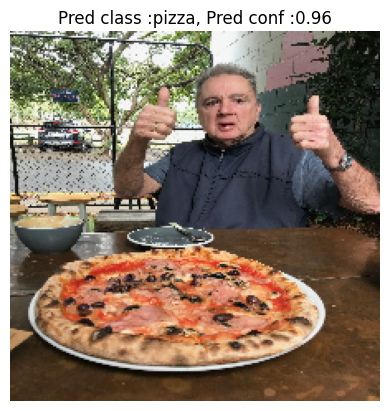

In [31]:
# make predictions using custom images
import matplotlib.pyplot as plt
for img in custom_food_images:
    print(img)
    img = load_and_prep_image(img, scale=False)
    pred_prob = model.predict(tf.expand_dims(img, axis=0))
    pred_class = class_names[pred_prob.argmax()]
    plt.figure()
    plt.imshow(img/255.)
    plt.title(f"Pred class :{pred_class}, Pred conf :{pred_prob.max():.2f}")
    plt.axis(False)